# Symbolic Aggregation Approximation

Creates a categorical representation of a time series. It does the following:
* converts the time series into [Piecewise Aggregate Approximation](piecewise_aggregate_approximation.ipynb) form
* converts the `PAA` representation into strings

In [340]:
from tslearn.piecewise import PiecewiseAggregateApproximation
from sklearn.preprocessing import StandardScaler
import scipy.stats as st
import numpy as np
import string
import matplotlib.pyplot as plt
from itertools import groupby
import itertools

plt.style.use("seaborn")

def sax(X, n_segments, n_symbols, debug=False, plot=False):
    """
    symbolic aggregate approximation
    """
    w = n_segments
    a = n_symbols

    ### if you want to use pre built packages you can use tslearn
    PAA = PiecewiseAggregateApproximation(n_segments=n_segments)
    X_paa = PAA.fit_transform(X)
    X_paa_inv = PAA.inverse_transform(X_paa)[0]

    
    #  discretize {num_groups} to {n_symbols}
    regions = [float(x) / n_symbols for x in range(1, n_symbols)]
    break_points = st.norm.ppf(regions, scale=1.) # percent point function
        
    letters = np.fromiter(string.ascii_lowercase, dtype=('<U2'))
    symbols = np.argmax(break_points >= X_paa, axis=1)
    
    if debug:
        symbols = letters[np.argmax(break_points >= X_paa, axis=1)]

        print(f"regions: {regions}\n")
        print(f"break point: {break_points}\n") 
        print(f"input: \n")
        for x, s in zip(X, symbols):
            print(s, x, x <= break_points, np.argmax(x <= break_points))
   
    if plot:
        inv_symbols = letters[np.argmax(break_points >= X_paa_inv, axis=1)]
        plt.figure(figsize=(24, 12))
        plt.plot(X, alpha=0.1, label="original")
        plt.plot(X_paa_inv ,alpha=0.5, label="paa")

        idx_symbols = sorted(zip(np.arange(len(inv_symbols)), inv_symbols), key=lambda x: x[1])

        for key, group in itertools.groupby(idx_symbols, lambda x: x[1]):
            empty_symbols = np.zeros(X.shape[0])
            empty_symbols[:] = np.nan
            idx = np.fromiter(map(lambda x: x[0], group), dtype=np.int)
            empty_symbols[idx.ravel()] = X_paa_inv[idx.ravel()].ravel()
            plt.plot(empty_symbols, label="sax " + str(key))

        plt.title(f"SAX with {n_symbols} symbols", fontsize=24)
        plt.legend(prop={'size': 18});
        
    return X_paa, symbols

In [333]:
n_samples, window_size, n_segments, n_symbols = 100, 6, 100 // 6, 8
rng = np.random.RandomState(42)
X = rng.randn(n_samples)

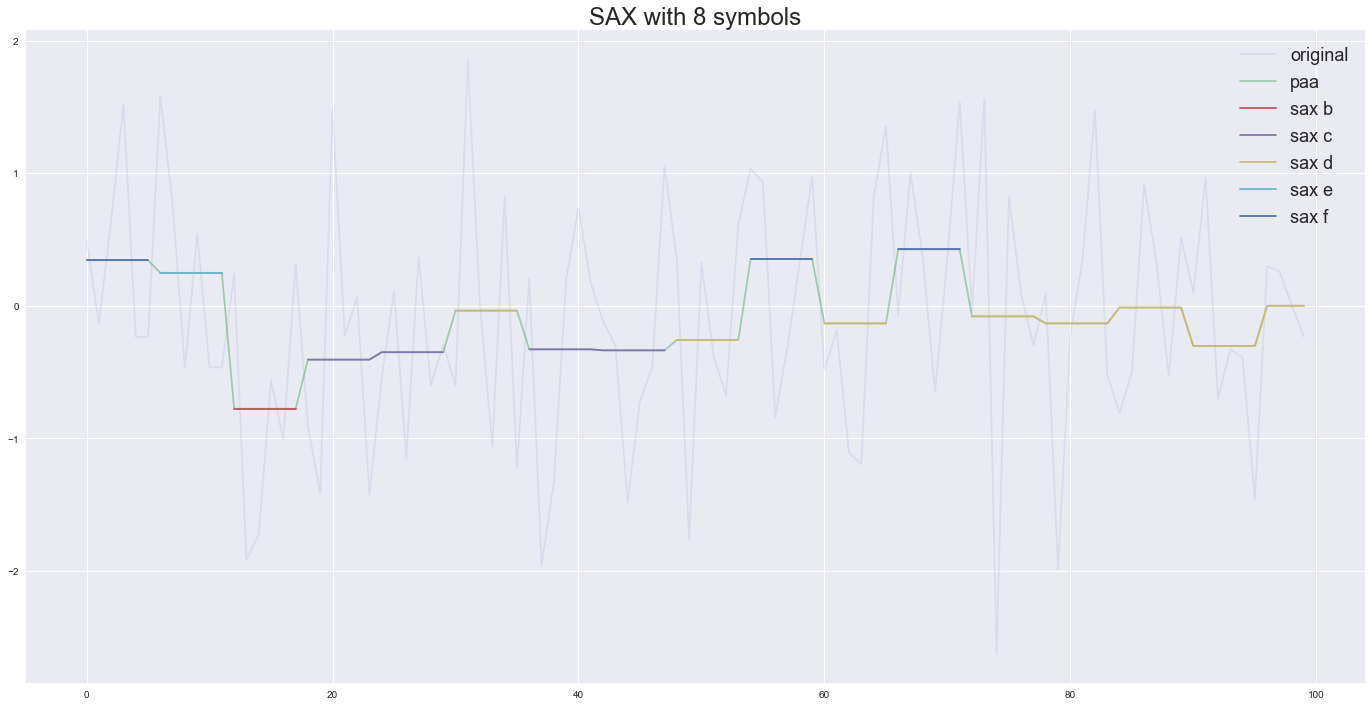

In [341]:
from itertools import groupby

X_paa, symbols = sax(X, n_segments, n_symbols, False, True)

### Resources
* [Probabilistic Discovery of Time Series Motifs](https://www.cs.ucr.edu/~eamonn/SIGKDD_Motif.pdf)
* [tslearn docs](https://tslearn.readthedocs.io/en/latest/auto_examples/plot_sax.html#sphx-glr-auto-examples-plot-sax-py)